# Multiclass Classification Project

<b>Learning Goals:</b><br/>
    - How to read different size images from a directory?
    - How to implement One-vs-One scheme for Multiclass classification?
    - How to use SVM for image classification?

<b><i>For this project we will be using the KERAS library for reading images </i></b>

### Dataset Preparation AND Image Pipelining

In [34]:
import numpy as np
import os 
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [35]:
p = Path("C:/Users/hp/Datasets/Images/images")
#print(type(p))
dirs = p.glob("*") # p.glob() excepts a regular expression as parameter and returns an ITERATOR that iterates over all the folders or directories that belong to that regular expression

labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}

# let us also create one array for the labels and one array of images
image_data = []
labels = []
    

for folder_dir in dirs:
    #print(folder_name) # returns the names of all the folders that are present in the images folder 
    label = str(folder_dir).split("\\")[-1][:-1] # to extract the labels of the folders present in the image folder
    #print(label)
    
    for img_path in folder_dir.glob("*.jpg"):
        #print(img_path)
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img) # will create an array of images , for example if you have 200 images or a batch size of 200 images and all the images are rgb images then you numpy array will be of the size/shape (200 * R-value * G-value * B-value)
        image_data.append(img_array)
        labels.append(labels_dict[label]) # where label will be the folder name that would be containing all images of 1 type

In [36]:
print(len(image_data))
print(len(labels))

808
808


In [37]:
# print(image_data)
# print(labels)

In [38]:
# Convert these arrays into numpy array
image_data = np.array(image_data,dtype = 'float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


#### Randomly Shuffle Our Data!

In [39]:
import random

combined = list(zip(image_data,labels)) ## we zipped image_data and labels array together and then shuffled the zipped arrays together, because if we won't have zipped them togehter then the labels array would have shuffled seprately and the image_data array would have shuffled seprately that would have destroyed the sequence as image in the image_data may not correspond to its label ie if for ex. there is an image of cat at index 3 in image_data then its possible that at index of 3 the labels is horse or any other labels instead of cat, that would be wrong. So to avoid this we zipped bothe the array together ,so that they can get shuffled in the same way.
random.shuffle(combined)

#unzip
image_data[:],labels[:] = zip(*combined) # '*' is used to unzip anything which have been zipped earlier 

### Visualize this data ie lets check whether we have loaded the images correctly or not


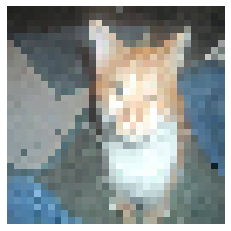

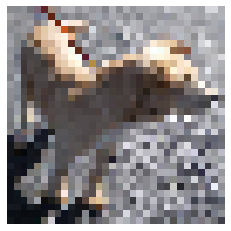

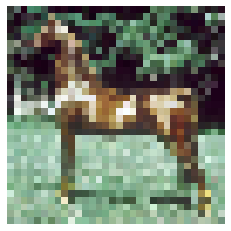

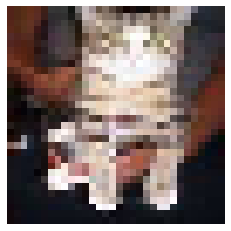

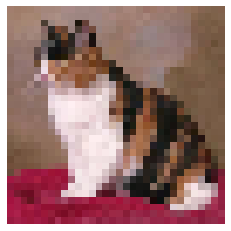

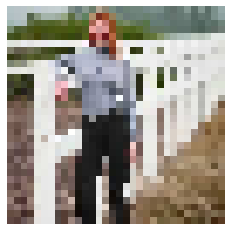

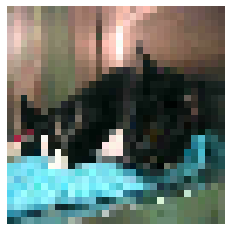

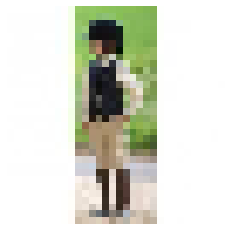

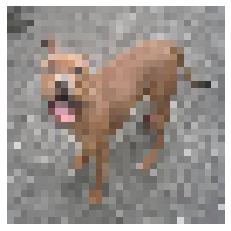

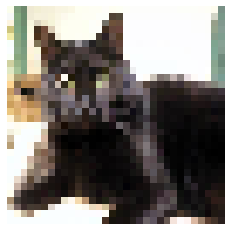

In [40]:
def drawimg(img):
    #from matplotlib import pyplot as plt
    plt.imshow(img)
    plt.axis("off") # to turn of the axis that surround the image
    plt.show()
    return

for i in range(10):
    drawimg(image_data[i])

## SVM Classifier

In [65]:
class SVM:
    """ SVM Class : Author : sakshamthukral"""
    def __init__(self,C=1.0):
        self.C=C # penality constant
        self.W=0 # weight
        self.b=0 # bias
        
    def hingeLoss(self,W,b,X,Y):
        loss = 0.0 # here we declared loss as a scalar
        loss += 0.5*np.dot(W,W.T) # but here the loss becomes a matrix as we are storing the result of dot product of two matrices in it
        
        m = X.shape[0] ## m->total number of examples
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i]) + b)
            loss += self.C*max(0,(1-ti))
        return loss[0][0] # because we want a scalar value of loss , and since loss became a matrix so we are retuning the element in its first row and first column
    
    def fit(self,X,Y,batch_size=500,learning_rate=0.001,maxItr=500):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        # initialize the models parameters
        W = np.zeros((1,no_of_features)) # we could also do other way round ie. W = np.zeros((no_of_features,1)) 
        bias = 0
        #print(self.hingeLoss(W,bias,X,Y))
        
        # Training from here
        # Weight and bias update rule that we discussed
        
        losses = [] # we are making this array of losses so that we can later check whether we were able to reduce the loss or not
        for i in range(maxItr):
            # Training Loop
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            
            ids = np.arange(no_of_samples) # generating the ideas for the samples in the dataset
            np.random.shuffle(ids)
            
            # Batch Gradient Descent(paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                # Assume 0 gradient for the batch 
                gradw = 0
                gradb = 0
                
                # iterate over all the examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        ti = Y[i] * (np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                # gradient for the batch is ready! Update W(weight),B(bias)
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        self.W = W
        self.b = bias
        return W,bias,losses

## We need to convert data for One-vs-One Classification!

In [43]:
#print(image_data.shape)

# since each image in image_data forms have a matrix of size 32x32x3 representing 100x100x3 features of each image and we 
# want all the features of the image to be stored in a single row format instead of matrix so we will reshape image_data as 
# follows :

M = image_data.shape[0] # where m is the total number of sample images present int he data
image_data = image_data.reshape(M,-1)
print(image_data.shape) # So now instead of having a matrix of features for each sample image in image_data it will now contain single row of features for each sample image.
print(labels.shape)

(808, 3072)
(808,)


now we can observe from above that there are 3072 features of each sample image being represented in a single row now<br/><br/><br/><br/><br/><br/>

In [18]:
no_of_classes = len(np.unique(labels))
print(no_of_classes)

4


#### Now building classWiseData() function that will build a dictionary by the name data that will store the model attributes like weights and the bias or different pairs of classes 

In [45]:
def classWiseData(x,y):
    data = {} # creating a dictionary by the name data that will be storing the the images in respect to their class keys
    for i in range(no_of_classes):
        data[i] = [] # creating keys for each class and initializing a value array in front of each class
    
    for i in range(x.shape[0]): # iterating over all the samples in the dataset and and appending EACH image data in the value array that corresponds to their respective class key value
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k]) # converting the array coressponding to each key into a numpy array
    
    return data   

In [46]:
data = classWiseData(image_data,labels)

In [47]:
print(data[0].shape[0]) # print(data[0].shape)
print(data[1].shape[0]) # print(data[1].shape)
print(data[2].shape[0]) # print(data[2].shape)
print(data[3].shape[0]) # print(data[3].shape)



202
202
202
202


so we can see that in our data dictionary we have 202 images correponding to each class and each image have further 3072 features of its own<br/><br/><br/><br/><br/>

In [54]:
def getDataPairForSVM(d1,d2):
    
    """Combines Data of two classes d1 and d2 into a single matrix"""
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    total_samples = l1+l2 # total number of samples present in the two classe. They define the total number of rows required. 
    features = d1.shape[1] # number of features of each sample . They define the total number of columns required
    
    data_pair = np.zeros((total_samples,features))
    data_labels = np.zeros((total_samples,))
    
    data_pair[:l1,:] = d1 # copying the data of the class d1 in the first part of data_pair matrix
    data_pair[l1:,:] = d2 # copying the data of the class d2 in the second part of data_pair matrix
    
    data_labels[:l1] = -1 # keeping first l1 lables of data_labels as class '-1' 
    data_labels[l1:] = +1 # keeping second part of data labels as class '+1'
    
    return data_pair,data_labels # data_pair reffers to the X data ie input data, Y data reffers to the output dataor output classes

## Training NC2 SVM's Part!

In [52]:
# creating an object of the SVM class
mySVM = SVM()

# For debugging the code we are checking only for the two data values
"""xp,yp = getDataPairForSVM(data[1],data[2])
w,b,loss = mySVM.fit(xp,yp,learning_rate = 0.00001,maxItr=1000)
#print(loss)
plt.plot(loss) """
# so we saw our curve is diverging instead of converging, so to remove this type of error,we decreased the learning rate value and then checked , and boom! now the curve starts converging

'xp,yp = getDataPairForSVM(data[1],data[2])\nw,b,loss = mySVM.fit(xp,yp,learning_rate = 0.00001,maxItr=1000)\n#print(loss)\nplt.plot(loss) '

In [66]:
def trainSVMs(x,y):
    svm_classifiers = {}
    for i in range(no_of_classes): #iterates over classes
        svm_classifiers[i]={}
        for j in range(i+1,no_of_classes): # iterates over classes
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate = 0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b) # i and j are the two classes for which the hypothesis have been found
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers

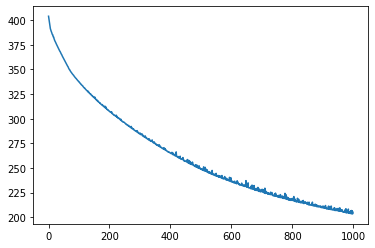

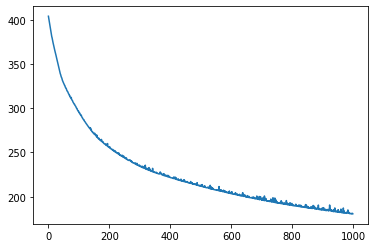

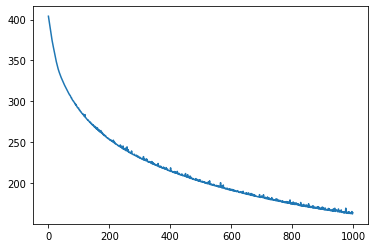

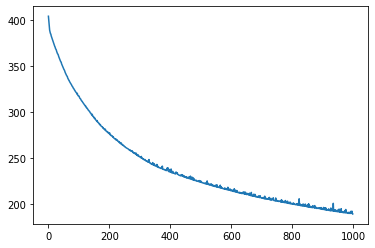

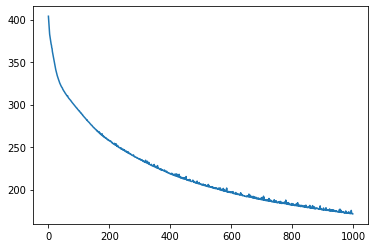

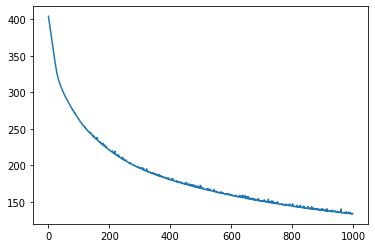

In [67]:
svm_classifiers = trainSVMs(image_data,labels)

In [68]:
# it basically means the parameters of the model in which the first class we trained was  class-'0' and the other class was class-'1'(dogs), these are the model parameters for the class cats and the class dogs

# Model parameters for cat and dog class
cat_dog = svm_classifiers[0][1]

# if you want the classifier between cats and human ie if you want the model parameters for cat an human classes do as follows:
cat_human = svm_classifiers[0][3]

#print(cat_dog[0]) # weights
print(cat_dog[1]) # value bias term
print(cat_dog[0].shape) # shape of weights matrix of cat_dog 
# print(cat_dog[1].shape) #it won't print anything because bias is not a matrix , its a scalar value
#print(cat_human[0]) #weights of classifer of classes cats and humans
#print(cat_human[1]) #bias of classifier of classes cat and humans

0.060339999999999776
(1, 3072)


### Prediction

In [69]:
# binaryPredict() is going to be the actual prediction of the SVM because it can give you only two classes ie -1 and 1
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1
    

In [81]:
def predict(x): # x reffers to some data
    count = np.zeros((no_of_classes,))
    
    for i in range(no_of_classes):
        for j in range(i+1,no_of_classes):
            w,b = svm_classifiers[i][j]
            # Take a majority prediction
            z = binaryPredict(x,w,b) # z is the output ie the prediction , ie the value of z would be either 1 or -1 
            # remember  we made a pair of class[i] and class[j] and kept set class[i]=-1 and class[j]=1
            if(z == 1):
                count[j] += 1 # j here reffers to the second class of the pair ie it can be 0,1,2 or 3 which also corresponds to the indices of numpy array count
            else:
                count[i] += 1 # i here reffers to the first class of the pair ie it can be 0,1,2 orn 3 which also corresponds to the indices of numpy array count
                
    final_prediction = np.argmax(count)
    #print(count)
    
    return final_prediction

In [82]:

print(predict(image_data[0])) # since we got the maximum value at the SECOND index of the count array therefore we will predict it to be a horse
print(labels[0])


0
0


In [83]:
def accuracy(x,y):
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction == y[i]):
            count += 1
    return count/x.shape[0]

In [84]:
accuracy(image_data,labels)

0.6002475247524752

### Using inbuilt SVM

In [85]:
from sklearn import svm

In [103]:
def custom_kernel(x1,x2):
    return np.square(np.dot(x1,x2.T))
svm_classifier = svm.SVC(kernel = 'linear',C=1.0)

In [104]:
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6398514851485149